## Setup of a basic simulation
In this notebook, we set up a basic simulation where a vessel moves over a 1D network path. The example aims to provides a basic understanding of some key OpenTNSim core functions and shows what an OpenTNSim model run looks like. 

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create graph](#2.-Create-graph)
3. [Create vessel](#3.-Create-vessel)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
import shapely.geometry
import pyproj

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim

# package(s) needed for inspecting the output
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt

print('This notebook is executed with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook is executed with OpenTNSim version 1.1.2


### 2. Create graph
Step one is to create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (links between the nodes in the plot below). We use the python package networkx to do this. 

For this example, we construct a network of 4 nodes linked by 3 edges. The edges are made bi-directional to allow for two-way traffic, which means that the graph in the end contains 6 edges.

<!-- Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry). -->

In [2]:
# specify a number of coordinates along your route (coords are specified in world coordinates: lon, lat)
coords = [
    [0,0],
    [0.1,0], 
    [0.2,0], 
    [0.3,0]] 

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()

# make your preferred Site class out of available mix-ins.
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

# add nodes
nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

In [4]:
# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
# create a positions dict for the purpose of plotting
positions = {}
for node in FG.nodes:
    positions[node] = (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

Number of nodes is 4:
Number of edges is 6:


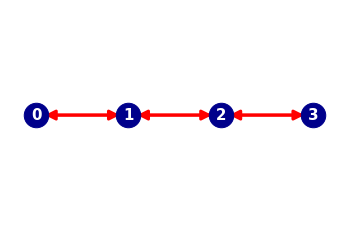

In [7]:
print('Number of nodes is {}:'.format(len(FG.nodes)))
print('Number of edges is {}:'.format(len(FG.edges)))

# draw edges, nodes and labels.
nx.draw_networkx_edges(FG,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()

### 3. Create vessel
Next we create a vessel class. We call this class a *TransportResource*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are required for a vessel in our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_, and 

In [8]:
# make your preferred vessel class out of available mix-ins.
TransportResource = type('Vessel', 
                         (opentnsim.core.Identifiable, opentnsim.core.Movable), {})

In [9]:
# create a dict with input data for the TransportResource class

# create a path along that the vessel needs to follow (in this case from the first node to the last node)
path = nx.dijkstra_path(FG, nodes[0].name, nodes[3].name)

# create a dict with all important settings
data_vessel = {"env": None,          # needed for simpy simulation
               "name": 'Vessel 1',   # required by Identifiable
               "geometry": None,     # required by Locatable
               "route": path,        # required by Routeable
               "v": 1}               # required by Movable

In [10]:
# create an instance of the TransportResource class using the input data dict
vessel = TransportResource(**data_vessel)

### 4. Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [11]:
# start simpy environment (specify the start time and add the graph to the environment)
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())
env.FG = FG

# add environment to the vessel, and specify the vessels current location (beginning of the path)
vessel.env = env                                        
vessel.geometry = env.FG.nodes[path[0]]['geometry']     

# specify the process that needs to be executed
env.process(vessel.move())

# start the simulation
env.run()

### 5. Inspect output
We can now analyse the simulation output by inspecting the vessel.log. Note that the _Log_ mix-in was included when we added _Movable_. The vessel.log keeps track of the moving activities of the vessel. For each discrete event OpenTNSim logs an event message, the start/stop time and the location. The vessel.log is of type dict. For convenient inspection it can be loaded into a Pandas dataframe. 

In [12]:
df = pd.DataFrame.from_dict(vessel.log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node 0 to node 1 start,2022-04-18 19:03:07.000000,0,POINT (0 0)
1,Sailing from node 0 to node 1 stop,2022-04-18 22:08:38.949079,0,POINT (0.1 0)
2,Sailing from node 1 to node 2 start,2022-04-18 22:08:38.949079,0,POINT (0.1 0)
3,Sailing from node 1 to node 2 stop,2022-04-19 01:14:10.898159,0,POINT (0.2 0)
4,Sailing from node 2 to node 3 start,2022-04-19 01:14:10.898159,0,POINT (0.2 0)
5,Sailing from node 2 to node 3 stop,2022-04-19 04:19:42.847238,0,POINT (0.3 0)


The log data shows that the vessel moved from its origin (*Node 0*) to its destination (*Node 3*), passing *Node 1* and *Node 2* in the process. OpenTNSim calculates the time it takes to pass an edge by computing its length (the greater circle distance between the nodes) divided by the sailing speed of the vessel. 

For this simple example we set the vessel speed (*v*) to 1 m/s. So the sailing time in seconds should be equal to the sailing distance in meters. We demonstrate this by plotting a distance-time graph.

In [13]:
def calculate_distance(orig, dest):
    """method to calculate the greater circle distance in meters from WGS84 lon, lat coordinates"""
    
    wgs84 = pyproj.Geod(ellps='WGS84')
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

In [14]:
# initialise variables
trip_distance = []
trip_time = []
start_time = simulation_start.timestamp()

# loop through vessel.log to collect information to plot 
for t in range(0,len(vessel.log["Message"])): 
    # extract origin, destination and step_time from log
    origin = (vessel.log["Geometry"][0].x,vessel.log['Geometry'][0].y)
    destination = (vessel.log["Geometry"][t].x,vessel.log['Geometry'][t].y)
    step_time = vessel.log["Timestamp"][t].timestamp()
    
    # add trip distance and time to lists
    trip_distance.append(calculate_distance(origin, destination))
    trip_time.append(step_time - start_time)

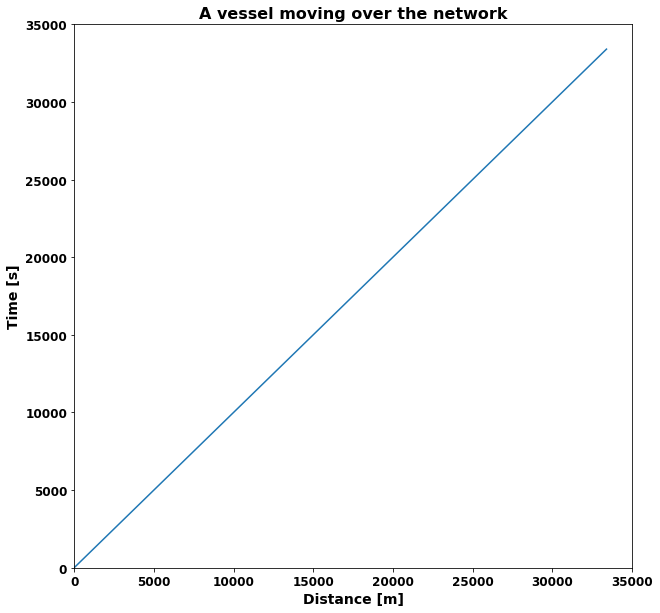

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

# specify fontsizes for the plot
titlesize = 16
labelsize = 14
ticksize = 12

# plot the distance time information
plt.plot(trip_distance, trip_time)

# set axis
plt.axis([0, 35000, 0, 35000])

# plot title
plt.title("A vessel moving over the network", fontweight='bold', fontsize=titlesize)

# plot axes labels
plt.xlabel("Distance [m]", weight = 'bold', fontsize=labelsize)
plt.ylabel("Time [s]", weight = 'bold', fontsize=labelsize)

# plot ticks
plt.xticks( weight = 'bold', fontsize=ticksize)
plt.yticks( weight = 'bold', fontsize=ticksize)

# show plot
plt.show()